In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import BinaryAccuracy

### DATA LOAD

In [18]:
dataset, dataset_info = tfds.load(
    "malaria", with_info=True, shuffle_files=True)

In [19]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)

    train_ds = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
    val_test_ds = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
    val_ds = val_test_ds.take(int(VAL_RATIO * DATASET_SIZE))
    test_ds = val_test_ds.skip(int(VAL_RATIO * DATASET_SIZE))
    return train_ds, val_ds, test_ds

In [20]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
train_ds, val_ds, test_ds = split(dataset['train'], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [21]:
len(train_ds)
len(val_ds)
len(test_ds)

2757

### DATA VIZ

In [22]:
def get_label_str(label):
  if label==0:
    return "Parasitized"
  else:
    return "Uninfected"

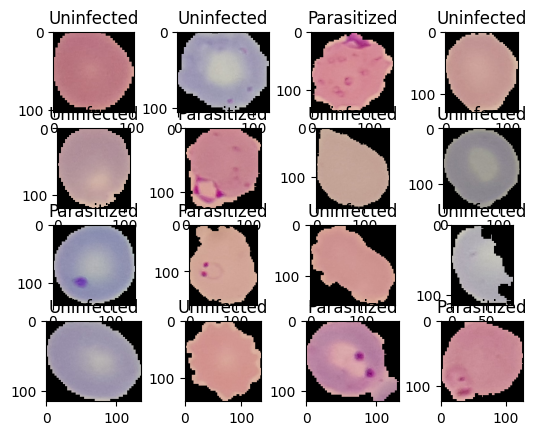

In [23]:
for i, sample in enumerate(train_ds.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(sample['image'])
  plt.title(get_label_str(sample['label'].numpy()))

### Image Pre-processing

In [24]:
IM_SIZE = 224
BATCH_SIZE = 32

In [25]:
def resize_rescale(inputs):
  return tf.image.resize(inputs['image'], (IM_SIZE, IM_SIZE))/255, inputs['label']

In [26]:
train_dataset = train_ds.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_ds.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_ds.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [27]:
for image, label in train_dataset.take(1):
  print(image.shape)
  print(label)

(32, 224, 224, 3)
tf.Tensor([0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 1 1], shape=(32,), dtype=int64)


### Model

In [28]:
model = tf.keras.Sequential([
                              InputLayer(input_shape = (IM_SIZE,IM_SIZE, 3)),
                              tf.keras.layers.Conv2D(filters=6, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
                              BatchNormalization(),
                              MaxPool2D(pool_size = 2, strides = 2),

                              tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
                              BatchNormalization(),
                              MaxPool2D(pool_size = 2, strides = 2),

                              Flatten(),

                              Dense(1000, activation='relu'),
                              BatchNormalization(),
                              Dense(100, activation='relu'),
                              BatchNormalization(),
                              Dense(1, activation='sigmoid')


])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1000)                │      46,657,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │         100,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,762,737 (178.39 MB)

 Trainable params: 46,760,493 (178.38 MB)

 Non-trainable params: 2,244 (8.77 KB)

In [29]:
model.compile(
    optimizer= Adam(learning_rate=0.01),
    loss = BinaryCrossentropy(),
    metrics = [BinaryAccuracy()],
)

In [30]:
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 10,
    verbose=1
)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - binary_accuracy: 0.8721 - loss: 0.3348 - val_binary_accuracy: 0.4933 - val_loss: 1.9524
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 78s 69ms/step - binary_accuracy: 0.9358 - loss: 0.2000 - val_binary_accuracy: 0.9230 - val_loss: 0.2355
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 80s 66ms/step - binary_accuracy: 0.9473 - loss: 0.1703 - val_binary_accuracy: 0.8838 - val_loss: 1.8789
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 82s 66ms/step - binary_accuracy: 0.9528 - loss: 0.1478 - val_binary_accuracy: 0.9114 - val_loss: 0.8899
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 46s 67ms/step - binary_accuracy: 0.9586 - loss: 0.1341 - val_binary_accuracy: 0.9350 - val_loss: 0.2106
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 51s 75ms/step - binary_accuracy: 0.9627 - loss: 0.1231 - val_binary_accuracy: 0.9419 - val_loss: 0.2260
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 77s 67ms/step - binary_accuracy: 0.9577 - loss: 0.1326 - val_binary_accuracy: 0.9136 - val_loss:

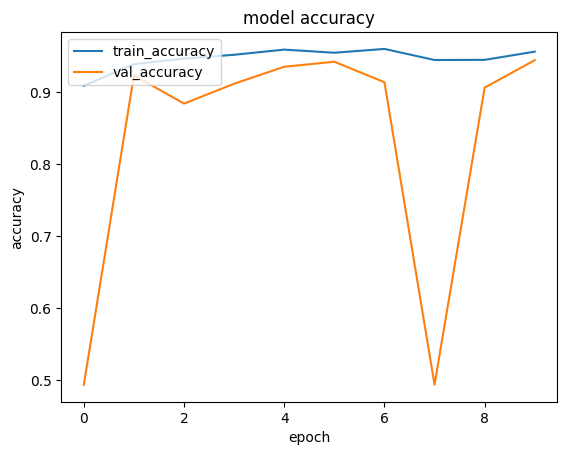

In [31]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
plt.show()

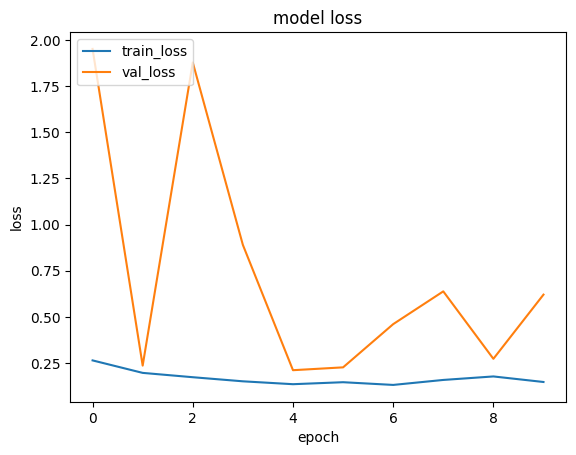

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

In [33]:
model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - binary_accuracy: 0.9471 - loss: 0.6558


[1.1194682121276855, 0.9397896528244019]

In [40]:
def parasite_or_not(x):
  if x<0.5:
    return "P"
  else:
    return "U"

In [38]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


'Parasitized'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


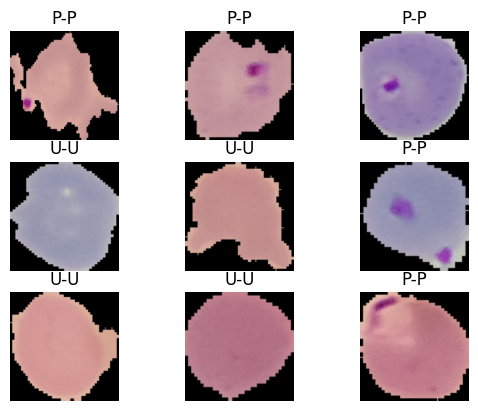

In [41]:
for image, label in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[i])
    plt.title(parasite_or_not(label.numpy()[i]) +'-'+parasite_or_not(model.predict(image)[i][0]))
    plt.axis('off')

## LOAD AND SAVE MY MODEL

In [44]:
model.save('lenet_model.keras')

In [45]:
loaded_model = tf.keras.models.load_model('lenet_model.keras')
loaded_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1000)                │      46,657,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │         100,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 140,283,725 (535.14 MB)

 Trainable params: 46,760,493 (178.38 MB)

 Non-trainable params: 2,244 (8.77 KB)

 Optimizer params: 93,520,988 (356.75 MB)